In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pickle
import bz2

In [2]:
# load data
model_dir = r'D:\\data\\pd_frame\\'


def sort_cols(test):
    return (test.reindex(sorted(test.columns), axis=1))


# factor names
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'DIVYILD', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET',
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA','SIZE','MOMENTUM','VALUE']

def get_formula(alpha):
    L = ["0", alpha]
    L.extend(style_factors)
    L.extend(industry_factors)
    return "Ret ~ " + " + ".join(L)


def wins(x, a, b):
    return (np.where(x <= a, a, np.where(x >= b, b, x)))


def clean_nas(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    for numeric_column in numeric_columns:
        df[numeric_column] = np.nan_to_num(df[numeric_column])

    return df

# problem 1

In [3]:
def estimate_factor_return(factor_name_list:str,factor_df:pd.DataFrame,output = 'ret'):
    factor_df = clean_nas(factor_df)
    #get liquad universe
    liquid_universe_df = factor_df.where(factor_df['IssuerMarketCap']>1e9).dropna(axis=0)
    res_list = []

    # winsoried for ret
    ret_series = liquid_universe_df.loc[:, 'Ret']
    up_q_float = ret_series.quantile(0.95)
    down_q_float = ret_series.quantile(0.05)
    liquid_universe_df.loc[:, 'Ret'] = wins(ret_series, down_q_float, up_q_float)
    for factor_name in factor_name_list:
        #winsorized
            #factor
        factor_series = liquid_universe_df.loc[:,factor_name]
        up_q_float = factor_series.quantile(0.95)
        down_q_float = factor_series.quantile(0.05)
        liquid_universe_df.loc[:, [factor_name]] = wins(factor_series,down_q_float,up_q_float)

        #get reg formula
        formula_str = get_formula(factor_name)
        #OLS regression
        model = smf.ols(formula = formula_str,data = liquid_universe_df)
        res = model.fit()
        res_list.append(res)
    if output=='ret':
        ret_list = [res_list[i].params[factor_name_list[i]] for i in range(len(res_list))]
        return ret_list
    return res_list

# problem 2

In [4]:
def factor_ret(factor_name_list:str,frames:dict):
    ret_list = []
    date_list = []
    for key,factor_df in frames.items():
        res = estimate_factor_return(factor_name_list,factor_df,output='ret')
        ret_list.append(res)
        date_list.append(key)
    ret_df = pd.DataFrame(index=date_list,data=ret_list,columns = factor_name_list)
    return ret_df

# problem 3

In [5]:
factor_list = ['STREVRSL', 'PROFIT', 'SENTMT']

factor_ret_df = pd.DataFrame()

for year in list(range(2003,2011)):
    frames = {}
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pickle.load(bz2.open(fil, "rb")))

    for x in frames:
        frames[x] = sort_cols(frames[x])

    ret_df = factor_ret(factor_list,frames)
    if factor_ret_df.empty:
        factor_ret_df = ret_df
    else:
        factor_ret_df = pd.concat([factor_ret_df,ret_df],axis=0)
    del frames


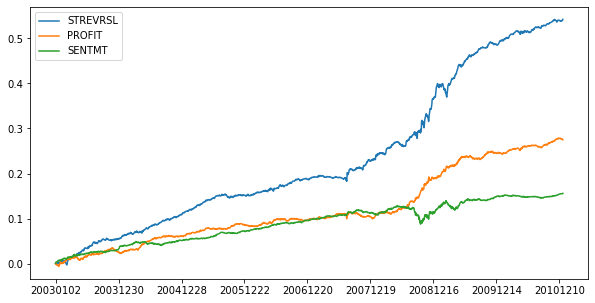

In [6]:
#plot
factor_ret_accu_df = np.add.accumulate(factor_ret_df,axis=0)
factor_ret_accu_df.plot(figsize=(10,5))
plt.legend()
plt.show()


In [7]:
def sharp(ror_d_array,annualized_bool=True):
    ror_d_array = ror_d_array.reshape(-1,1)
    ror_y_float = np.exp(np.log(1+ror_d_array).sum() / (len(ror_d_array)/252))-1
    std_y_float = np.std(ror_d_array)*np.sqrt(252)
    return (ror_y_float-0.03319)/std_y_float
def VaR_series(confidence_level_float,daily_ret_df,period_int=1):
    confidence_level_float *=100
    daily_ret_array = daily_ret_df.values.copy()
    Var_float = np.percentile(daily_ret_array,100-confidence_level_float,interpolation='midpoint')*period_int
    return Var_float

def VaR(confidence_level_float,daily_ret_df,period_int = 1,method_str='series'):
    if method_str=='series':
        return VaR_series(confidence_level_float,daily_ret_df,period_int)
    elif method_str=='std':
        return VaR_std_m(confidence_level_float, daily_ret_df,period_int)

def ETL(confidence_level_float,daily_ret_df,period_int = 1,method_str='series'):
    VaR_float = VaR(confidence_level_float,daily_ret_df,period_int,method_str)
    etl_ret_df = daily_ret_df[daily_ret_df<=VaR_float]
    etl_float = etl_ret_df.mean().values[0]
    return etl_float

In [8]:
factor_return_df = factor_ret_df*1e6
factor_ret_annual_df = factor_ret_accu_df.iloc[[-1],:]/(factor_ret_accu_df.shape[0]/252)
factor_ret_annual_df.index = ['Annualized Ret']
factor_ret_annual_df.loc['SHARPE',:]  = [0]*factor_ret_annual_df.shape[1]
factor_ret_annual_df.loc['VaR',:]  = [0]*factor_ret_annual_df.shape[1]
factor_ret_annual_df.loc['ETL',:]  = [0]*factor_ret_annual_df.shape[1]
for i in range(factor_ret_annual_df.shape[1]):
    factor_ret_annual_df.iloc[0,i] = str(np.round(factor_ret_annual_df.iloc[0,i]*100,2))+'%'
    factor_ret_annual_df.iloc[1,i] = np.round(sharp(factor_ret_df.iloc[:,i].values),2)
    factor_ret_annual_df.iloc[2,i] = np.round(VaR(0.95,factor_return_df.iloc[:,[i]]),2)

factor_ret_annual_df.head()

,STREVRSL,PROFIT,SENTMT
Annualized Ret,6.78%,3.44%,1.95%
SHARPE,1.65,0.11,-0.99
VaR,-1476.99,-1233.41,-1080.16
ETL,0.0,0.0,0.0


The result shows that STREVRSL maybe a potential alpha for its relatively high return and SHARPE Ratio.

The factor return is the result after being orthogonalized to style factors and industry factors. Therefore, we can nreturalized the factor to other factors by regressing over other factors and using the residuals as netrualzied factor.

Afterwards, we construct a portfolio by longing stocks with high exposure to the factor and short those with low exposure. The cumulative return derived above should represent the the return of such portfolio.